# Real-Time Multichannel EEG Streaming Application

![](./assets/.png)

## Prerequisites

| What? | Why? |
| --- | --- |
| [Index: Intro, Workflows, Extensions](./index.ipynb) | For context and workflow selection/feature guidance |
| [Recommended Workflow](./multichan.ipynb) | For live downsampling with in-memory Pandas DataFrame |

## Overview

This tutorial guides you through building a real-time multichannel EEG streaming application using LSL, mne, holoviews, and panel. The application allows you to:

- Stream EEG data from a sample dataset or CPU usage data.
- Visualize the streaming data in real-time with interactive controls.
- Start, pause, and stop the data stream.
- Select different data sources and channels.

## Why Stream EEG Data?
Streaming EEG data in real-time is crucial for applications like neurofeedback, brain-computer interfaces, and live monitoring during experiments. By visualizing the data as it streams, you can gain immediate insights and respond promptly to changes.

## Imports and Configuration


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
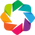

In [2]:
import time
import uuid
import mne
import holoviews as hv
import panel as pn
import param
import numpy as np
import pandas as pd
from mne_lsl.datasets import sample
from mne_lsl.player import PlayerLSL
from mne_lsl.stream import StreamLSL
from holoviews.streams import Buffer
import psutil

hv.extension('bokeh')
pn.extension()


## Creating Data Sources

We will create two data sources:
1. **CPU Usage:** Streams CPU usage percentages per core.
2. **EEG Usage:** Streams EEG data from a sample dataset.

### CPU Usage Data Source
The `CPU_Usage` class streams CPU usage data using the `psutil` library. This acts as a sort of simple test bench for us to stream some real data and make sure the plotting application is working.

In [5]:
class CPU_Usage():
    def __init__(self, sampling_interval=0.25):
        self.num_cores = psutil.cpu_count(logical=True)
        self.channel_names = [f'CPU_{i}' for i in range(self.num_cores)]
        self._sampling_interval = sampling_interval

    def get_channel_names(self):
        return self.channel_names

    @property
    def sampling_interval(self):
        return self._sampling_interval

    def start(self):
        pass  # No action needed for CPU monitoring

    def stop(self):
        pass  # No action needed for CPU monitoring

    def generate_data(self):
        cpu_percent = psutil.cpu_percent(percpu=True)
        timestamp = pd.Timestamp.now()
        data = {'time': [timestamp]}
        for ch, usage in zip(self.channel_names, cpu_percent):
            data[ch] = usage
        return pd.DataFrame(data)


### LSL File Stream Data Source
The `LSL_File_Stream` class streams EEG data via a mock `LSL` live stream from a saved file, using utilities from the `mne` and `mne_lsl` libraries.


In [6]:
class LSL_File_Stream():
    def __init__(self, fname, chunk_size=200, buffer_size=2, picks=None):
        self.source_id = uuid.uuid4().hex
        self.fname = fname
        self.chunk_size = chunk_size
        self.player = PlayerLSL(self.fname, chunk_size=self.chunk_size, source_id=self.source_id)
        self.stream = StreamLSL(bufsize=buffer_size, source_id=self.source_id)
        self._sampling_interval = self.chunk_size / self.player.info['sfreq']
        self.streaming = False

        # If picks is None, find all EEG channels
        if picks is None:
            eeg_indices = mne.channel_indices_by_type(self.player.info)['eeg']
            self.channel_names = [self.player.ch_names[i] for i in eeg_indices]
        else:
            self.channel_names = picks

    def get_channel_names(self):
        return self.channel_names

    @property
    def sampling_interval(self):
        return self._sampling_interval

    def start(self):
        if not self.streaming:
            self.player.start()
            self.stream.connect()
            self.stream.pick("eeg")
            self.stream.add_reference_channels("CPz")
            self.stream.set_eeg_reference("average")
            self.streaming = True

    def stop(self):
        if self.streaming:
            self.stream.disconnect()
            self.player.stop()
            self.streaming = False

    def generate_data(self):
        if not self.streaming:
            return pd.DataFrame(columns=['time'] + self.channel_names)
        data, ts = self.stream.get_data(self.stream.n_new_samples / self.stream.info["sfreq"], picks=self.channel_names)
        if data.size > 0:
            new_data = pd.DataFrame({'time': ts})
            for i, ch in enumerate(self.channel_names):
                new_data[ch] = data[i]
            return new_data
        else:
            return pd.DataFrame(columns=['time'] + self.channel_names)


## Building the Streaming Application
The StreamingApp class handles the user interface and streaming logic, integrating the data sources with interactive controls.

In [10]:
class StreamingApp(param.Parameterized):
    def __init__(self, data_sources, notebook=False):
        super().__init__()
        self.data_sources = data_sources
        self.notebook = notebook

        # Create mappings from data source names to instances
        self.data_source_names = [type(ds).__name__ for ds in data_sources]
        self.data_source_instances = {type(ds).__name__: ds for ds in data_sources}
        self.data_source = self.data_source_names[0]  # Default selection

        self.update_channel_names()
        self.buffer_length = 1000  # Adjust as needed
        self.streaming = False
        self.paused = False
        self.task = None
        self.data_generator = None

        # Initialize the buffer here after channel names are set
        self.buffer = Buffer(data=self.initial_data(), length=self.buffer_length)

        self.create_widgets()
        self.create_layout()

    def update_channel_names(self):
        data_source_instance = self.data_source_instances[self.data_source]
        self.channel_names = data_source_instance.get_channel_names()
        # Update buffer with new channel names if buffer is initialized
        if hasattr(self, 'buffer'):
            self.buffer.clear()
            self.buffer.data = self.initial_data()

    def initial_data(self):
        # No initial data
        return pd.DataFrame({'time': [], **{ch: [] for ch in self.channel_names}})

    def create_widgets(self):
        # Dropdown widget for selecting data source
        self.data_source_widget = pn.widgets.Select(
            name='Data Source',
            options=self.data_source_names,
            value=self.data_source
        )
        # Watch for changes in the data source selector
        self.data_source_widget.param.watch(self.on_data_source_change, 'value')

        self.radio_group = pn.widgets.RadioButtonGroup(
            name='Stream Control',
            options=['Start', 'Pause', 'Stop'],
            value='Stop',
            button_type='default',
            sizing_mode='stretch_width',
            stylesheets=[ """
            :host(.solid) .bk-btn.bk-btn-default.bk-active {
                background-color: #b23c3c;
            }
            """]
        )
        self.radio_group.param.watch(self.handle_state_change, 'value')

    def on_data_source_change(self, event):
        self.stop_stream()
        self.data_source = event.new
        self.update_channel_names()
        # Update the plot
        self.plot_pane.object = self.blank_bare_plot()

    def handle_state_change(self, event):
        if event.new == 'Start':
            self.start_stream()
        elif event.new == 'Pause':
            self.pause_stream()
        elif event.new == 'Stop':
            self.stop_stream()

    def create_layout(self):
        # Start with a blank plot
        self.plot_pane = pn.pane.HoloViews(self.blank_bare_plot())
        if self.notebook:
            self.layout = pn.Column(
                self.data_source_widget,
                self.radio_group,
                self.plot_pane,
                align='center',
            )
        else:
            sidebar = pn.Column(
                pn.WidgetBox(
                    self.data_source_widget,
                    self.radio_group,
                ),
                align='center',
                sizing_mode='stretch_width',
            )
            self.template = pn.template.FastListTemplate(
                main=[self.plot_pane],
                sidebar=[sidebar],
                title="Multi-Channel Streaming App",
                theme="dark",
                accent="#2e008b",
            )

    def start_stream(self):
        if not self.streaming:
            self.streaming = True
            self.paused = False
            # Get the selected data source instance
            self.data_generator = self.data_source_instances[self.data_source_widget.value]
            self.data_generator.start()  # Start the data source
            self.buffer.clear()
            # Replace the plot with the live streaming plot
            self.plot_pane.object = self.create_streaming_plot()
            # Start the periodic callback
            sampling_interval_ms = int(self.data_generator.sampling_interval * 1000)
            self.task = pn.state.add_periodic_callback(
                self.stream_data, period=sampling_interval_ms, count=None
            )
        elif self.streaming and self.paused:
            self.paused = False
            if self.task is None:
                # Restart the periodic callback if it was stopped
                sampling_interval_ms = int(self.data_generator.sampling_interval * 1000)
                self.task = pn.state.add_periodic_callback(
                    self.stream_data, period=sampling_interval_ms, count=None
                )

    def pause_stream(self):
        if self.task:
            self.task.stop()
            self.task = None
        self.paused = True

    def stop_stream(self):
        if self.streaming:
            self.streaming = False
            self.paused = False
            if self.task:
                self.task.stop()
                self.task = None
            if self.data_generator is not None:
                self.data_generator.stop()  # Stop the data source
            self.radio_group.value = 'Stop'
            self.plot_pane.object = self.blank_bare_plot()
            self.buffer.clear()
            self.buffer.data = self.initial_data()
            self.data_generator = None

    def create_streaming_plot(self):
        # Create the streaming plot using DynamicMap
        def create_plot(data):
            overlays = {}
            for ch in self.channel_names:
                if ch in data.columns and not data[ch].dropna().empty:
                    # Set the label to match the key
                    curve = hv.Curve((data['time'], data[ch]), label=ch).opts(
                        line_width=2,
                        subcoordinate_y=True,
                    )
                    overlays[ch] = curve
            if overlays:
                ndoverlay = hv.NdOverlay(overlays).apply.opts(
                    legend_position='right',
                    responsive=True,
                    min_height=600,
                    framewise=True,
                    title='',
                )
                return ndoverlay
            else:
                return self.blank_stream_plot()

        dmap = hv.DynamicMap(create_plot, streams=[self.buffer])
        return dmap

    def blank_bare_plot(self):
        return hv.Curve([]).opts(yaxis='bare', xaxis='bare', min_height=600, responsive=True)

    def blank_stream_plot(self):
        # Create an empty NdOverlay with the expected keys and labels
        empty_curves = {ch: hv.Curve([]).relabel(ch).opts(subcoordinate_y=True) for ch in self.channel_names}
        ndoverlay = hv.NdOverlay(empty_curves).opts(
            legend_position='right',
            responsive=True,
            min_height=600,
            title=''
        )
        return ndoverlay

    def stream_data(self):
        if not self.streaming or self.paused:
            return
        with pn.io.unlocked():
            # Use the data generator to get new data
            new_data_df = self.data_generator.generate_data()
            if not new_data_df.empty:
                self.buffer.send(new_data_df)

    def create_servable_app(self):
        if self.notebook:
            return self.layout
        else:
            return self.template.servable()

### Running the Application
Instantiate the data sources and create the application.

In [12]:
# Instantiate data sources
data_source_cpu_usage = CPU_Usage(sampling_interval=0.05)
data_source_eeg_usage = LSL_File_Stream(sample.data_path() / "sample-ant-raw.fif", chunk_size=200, buffer_size=2,
                                        picks=['Fp1', 'F7', 'F4', 'F8', 'FC5', 'FC2', 'T7', 'P7', 'CP2',  'CP6', 'P3', 'P4', 'O1', 'O2',])

# Create the app with both data sources
app = StreamingApp(data_sources=[data_source_eeg_usage, data_source_cpu_usage], notebook=True)
app.create_servable_app()

Opening raw data file /Users/droumis/mne_data/MNE-LSL-data/sample/sample-ant-raw.fif...
Isotrak not found
    Range : 0 ... 153602 =      0.000 ...   150.002 secs
Ready.
Reading 0 ... 153602  =      0.000 ...   150.002 secs...


Column(align='center')
    [0] Select(name='Data Source', options=['LSL_File_Stream', ...], value='LSL_File_Stream')
    [1] RadioButtonGroup(name='Stream Control', options=['Start', 'Pause', ...], sizing_mode='stretch_width', stylesheets=['\n          ...], value='Stop')
    [2] HoloViews(Curve, sizing_mode='stretch_both')

## Using the Application
- **Select Data Source:** Use the dropdown to select either CPU_Usage or EEG_Usage.
- **Control Streaming:**
- Click **Start** to begin streaming data from the selected source.
  - Click **Pause** to temporarily halt data updates without stopping the data source.
  - Click **Stop** to stop data updates and the data source itself.
- **Switching Data Sources:**
  - When you select a different data source, the app automatically stops the current data source before starting the new one.

## Conclusion
In this tutorial, we've built a real-time multichannel streaming application that can handle different data sources, including EEG data and CPU usage. By leveraging mne, holoviews, and panel, we've created an interactive visualization tool that can be extended and customized for various real-time data streaming needs.

## What Next?
Customization: Modify the application to include additional data sources or customize the visualization options.
Deployment: Deploy the application as a standalone web app using panel serve.
Data Analysis: Extend the application to include data analysis features such as filtering, feature extraction, or event detection.

## Related Resources

| What? | Why? |
| --- | --- |
|MNE-Python Docs|	For more information on EEG data handling |
|MNE-LSL Docs| |
|LSL Docs|